In [1]:
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Utils

In [3]:
def plot_decision_boundary(model, X, y, title=None):
    # Put everything on CPU
    X, y = X.cpu(), y.cpu()
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.01),
                            torch.arange(y_min, y_max, 0.01),
                            indexing="xy")
    grid = torch.cat((xx.reshape(-1, 1), yy.reshape(-1, 1)), dim=1).to(next(model.parameters()).device)
    model.eval()
    with torch.inference_mode():
        logits = model(grid)
        if logits.shape[1] == 1:
            # Binary classification
            pred_func = torch.round(torch.sigmoid(logits)).squeeze()
        else:
            # Multiclass classification
            pred_func = torch.softmax(logits, dim=1).argmax(dim=1)
    z = pred_func.reshape(xx.shape).cpu()
    plt.contourf(xx, yy, z, cmap=plt.cm.RdYlBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
    plt.xlabel("Feature 0")
    plt.ylabel("Feature 1")
    if title:
        plt.title(title)
    else:
        plt.title("Decision Boundary")
    plt.show()

In [4]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Clasificacion Binaria

In [5]:
# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

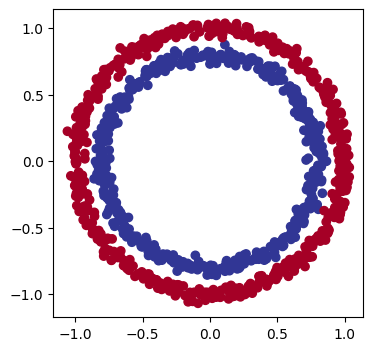

In [6]:
eje_x = X[:, 0]
eje_y = X[:, 1]
plt.figure(figsize=(4, 4))
plt.scatter(x=eje_x, y=eje_y, c=y, cmap=plt.cm.RdYlBu)


In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

for i in range(5):
    print(f"Feature: {X[i]} Target: {y[i]}")

Feature: tensor([0.7542, 0.2315]) Target: 1.0
Feature: tensor([-0.7562,  0.1533]) Target: 1.0
Feature: tensor([-0.8154,  0.1733]) Target: 1.0
Feature: tensor([-0.3937,  0.6929]) Target: 1.0
Feature: tensor([ 0.4422, -0.8967]) Target: 0.0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

modelo_binario = CircleModelV2().to(device)
print(modelo_binario)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(modelo_binario.parameters(), lr=0.1)

In [11]:
torch.manual_seed(42)
epochs = 1000

# Convertir data a CUDA si es posible
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    modelo_binario.train()

    # Convertir logits -> probabilidades
    y_logits = modelo_binario(X_train).squeeze()
    probabilities = torch.sigmoid(y_logits)

    # 1. Forward pass
    y_pred = torch.round(probabilities) 
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    modelo_binario.eval()
    with torch.inference_mode():
      # Convertir logits -> probabilidades
      test_logits = modelo_binario(X_test).squeeze()
      probabilities = torch.sigmoid(test_logits)

      # 1. Forward pass
      test_pred = torch.round(probabilities) 
      
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Mostrar resultados cada 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69528, Accuracy: 47.75% | Test Loss: 0.69643, Test Accuracy: 43.00%
Epoch: 100 | Loss: 0.68467, Accuracy: 55.75% | Test Loss: 0.68699, Test Accuracy: 55.50%
Epoch: 200 | Loss: 0.67063, Accuracy: 63.88% | Test Loss: 0.67432, Test Accuracy: 64.00%
Epoch: 300 | Loss: 0.64502, Accuracy: 83.25% | Test Loss: 0.65081, Test Accuracy: 80.50%
Epoch: 400 | Loss: 0.59484, Accuracy: 96.12% | Test Loss: 0.60536, Test Accuracy: 94.50%
Epoch: 500 | Loss: 0.49370, Accuracy: 99.62% | Test Loss: 0.51372, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.33164, Accuracy: 99.88% | Test Loss: 0.36514, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.18670, Accuracy: 100.00% | Test Loss: 0.22630, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.11898, Accuracy: 100.00% | Test Loss: 0.15474, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.07291, Accuracy: 100.00% | Test Loss: 0.10390, Test Accuracy: 100.00%


In [12]:
modelo_binario.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(modelo_binario(X_test))).squeeze()
y_preds[:10], y[:10] 

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

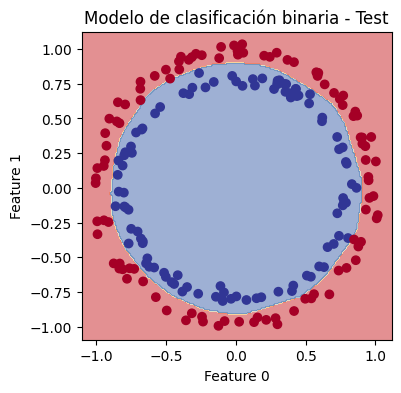

In [13]:
plt.figure(figsize=(4, 4))
plot_decision_boundary(modelo_binario, X_test, y_test, title="Modelo de clasificación binaria - Test")

# Clasificacion MultiClase

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


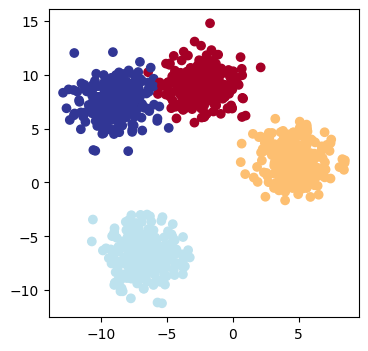

In [14]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, 
                            cluster_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(4, 4))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);


In [15]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
modelo_multiclase = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES).to(device)
modelo_multiclase

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelo_multiclase.parameters(), lr=0.1) 

In [17]:
torch.manual_seed(42)
epochs = 100

# Convertir data a CUDA si es posible
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    modelo_multiclase.train()

    # 1. Forward pass
    y_logits = modelo_multiclase(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    modelo_multiclase.eval()
    with torch.inference_mode():
      # Convertir logits -> probabilidades
      test_logits = modelo_multiclase(X_blob_test)
      probabilities = torch.softmax(test_logits, dim=1)

      # 1. Forward pass
      test_pred = probabilities.argmax(dim=1)
      
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Mostrar resultados cada 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 


Epoch: 0 | Loss: 1.36115, Acc: 45.50% | Test Loss: 0.97027, Test Acc: 75.50%
Epoch: 10 | Loss: 0.18147, Acc: 99.12% | Test Loss: 0.16183, Test Acc: 99.50%
Epoch: 20 | Loss: 0.08279, Acc: 99.12% | Test Loss: 0.07487, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05800, Acc: 99.12% | Test Loss: 0.05089, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04732, Acc: 99.12% | Test Loss: 0.04007, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04146, Acc: 99.12% | Test Loss: 0.03393, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03779, Acc: 99.12% | Test Loss: 0.02998, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03530, Acc: 99.12% | Test Loss: 0.02722, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03352, Acc: 99.12% | Test Loss: 0.02520, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03218, Acc: 99.12% | Test Loss: 0.02364, Test Acc: 99.50%


In [18]:
modelo_multiclase.eval()
with torch.inference_mode():
    y_logits = modelo_multiclase(X_blob_test)
y_logits[:10]

tensor([[-0.4070,  5.9570, -3.2424, -4.0865],
        [ 1.2719, -5.0065,  0.1010,  7.3155],
        [-4.6324, -2.0671,  6.1003, -1.5261],
        [-1.6594,  4.7202, -1.7858, -3.1129],
        [ 6.1711,  0.7056, -3.8144, -2.2227],
        [ 1.2904, -5.9982,  0.2551,  8.7842],
        [-4.0084, -1.4189,  5.3558, -1.7461],
        [ 6.1375, -1.3787, -2.7650, -0.2662],
        [-5.7341, -3.1325,  7.3536, -0.9757],
        [ 6.2653, -0.7793, -2.9639, -1.1962]], device='cuda:0')

In [19]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


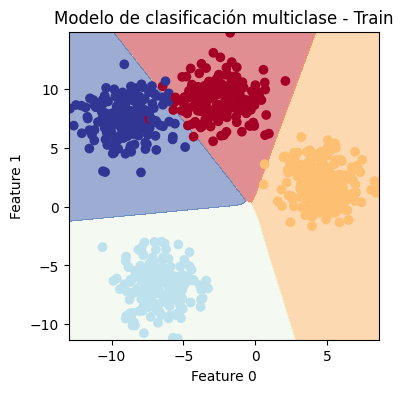

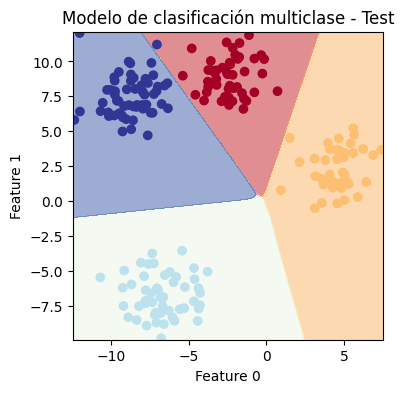

In [20]:
plt.figure(figsize=(4, 4))
plot_decision_boundary(modelo_multiclase, X_blob_train, y_blob_train, title="Modelo de clasificación multiclase - Train")
plt.figure(figsize=(4, 4))
plot_decision_boundary(modelo_multiclase, X_blob_test, y_blob_test, title="Modelo de clasificación multiclase - Test")

